In [1]:
!pip install eli5==0.13.0

# 한글 폰트 사용을 위한 라이브러리입니다.
!apt-get install -y fonts-nanum

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.


In [2]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import eli5
from eli5.sklearn import PermutationImportance

In [3]:
# 열 다 보이게 설정
pd.set_option('display.max_columns', None)
# 행 다 보이게 설정
pd.set_option('display.max_rows', None)

In [4]:
# 데이터 로드

train_path = '/root/AI_STAGE/upstageailab-ml-competition-ml-2/1.Data/train.csv'
test_path  = '/root/AI_STAGE/upstageailab-ml-competition-ml-2/1.Data/test.csv'
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

In [5]:
train.shape, test.shape

((1118822, 52), (9272, 51))

In [6]:
display(train.head(3))

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,도로명,해제사유발생일,등기신청일자,거래유형,중개사소재지,"k-단지분류(아파트,주상복합등등)",k-전화번호,k-팩스번호,단지소개기존clob,k-세대타입(분양형태),k-관리방식,k-복도유형,k-난방방식,k-전체동수,k-전체세대수,k-건설사(시공사),k-시행사,k-사용검사일-사용승인일,k-연면적,k-주거전용면적,k-관리비부과면적,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-135㎡초과,k-홈페이지,k-등록일자,k-수정일자,고용보험관리번호,경비비관리형태,세대전기계약방법,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,언주로 3,NaN,,-,-,아파트,025776611,025776673,NaN,분양,자치관리,계단식,개별난방,8.0,270.0,우성건설,모름,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,NaN,NaN,2022-11-09 20:10:43.0,2023-09-23 17:21:41.0,NaN,직영,단일계약,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,124000
1,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,22,4,1987,언주로 3,NaN,,-,-,아파트,025776611,025776673,NaN,분양,자치관리,계단식,개별난방,8.0,270.0,우성건설,모름,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,NaN,NaN,2022-11-09 20:10:43.0,2023-09-23 17:21:41.0,NaN,직영,단일계약,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,123500
2,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,54.98,201712,28,5,1987,언주로 3,NaN,,-,-,아파트,025776611,025776673,NaN,분양,자치관리,계단식,개별난방,8.0,270.0,우성건설,모름,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,NaN,NaN,2022-11-09 20:10:43.0,2023-09-23 17:21:41.0,NaN,직영,단일계약,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,91500


In [7]:
display(test.head(3))

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,도로명,해제사유발생일,등기신청일자,거래유형,중개사소재지,"k-단지분류(아파트,주상복합등등)",k-전화번호,k-팩스번호,단지소개기존clob,k-세대타입(분양형태),k-관리방식,k-복도유형,k-난방방식,k-전체동수,k-전체세대수,k-건설사(시공사),k-시행사,k-사용검사일-사용승인일,k-연면적,k-주거전용면적,k-관리비부과면적,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-135㎡초과,k-홈페이지,k-등록일자,k-수정일자,고용보험관리번호,경비비관리형태,세대전기계약방법,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.9700,202307,26,5,1987,언주로 3,NaN,,직거래,-,아파트,025776611,025776673,NaN,분양,자치관리,계단식,개별난방,8.0,270.0,우성건설,모름,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,NaN,NaN,2022-11-09 20:10:43.0,2023-09-23 17:21:41.0,NaN,직영,단일계약,직영,4858.00,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.057210,37.476763,2022-11-17 10:19:06.0
1,서울특별시 강남구 개포동,651-1,651.0,1.0,개포더샵트리에,108.2017,202308,15,10,2021,개포로 311,NaN,,중개거래,서울 강남구,아파트,025763999,025763998,NaN,분양,위탁관리,계단식,지역난방,2.0,232.0,포스코,개포우성9차모델링조합,2021-12-01 00:00:00.0,44951.0,24878.0,31174.0,0.0,0.0,232.0,NaN,thesharp-trieh.hthomeservice.com/#/feeManage?_...,2022-01-05 18:02:23.0,2023-09-23 17:23:08.0,NaN,위탁,종합계약,위탁,2724.46,305.0,의무,2022-02-23 13:01:10.0,Y,N,127.056394,37.484892,2022-02-23 11:05:05.0
2,서울특별시 강남구 개포동,652,652.0,0.0,개포우성3차,161.0000,202307,28,15,1984,개포로 307,NaN,,중개거래,서울 강남구,아파트,025749116,025749094,2888.0,분양,자치관리,혼합식,지역난방,5.0,405.0,우성건설,우성건설,1984-12-31 00:00:00.0,63304.0,53437.0,61064.0,0.0,0.0,285.0,NaN,NaN,NaN,2023-09-23 17:15:43.0,21380015910,직영,단일계약,위탁,61064.24,419.0,의무,1984-12-22 00:00:00.0,Y,N,127.055990,37.483894,2013-03-07 09:46:28.0


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1118822 entries, 0 to 1118821
Data columns (total 52 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   시군구                     1118822 non-null  object 
 1   번지                      1118597 non-null  object 
 2   본번                      1118747 non-null  float64
 3   부번                      1118747 non-null  float64
 4   아파트명                    1116696 non-null  object 
 5   전용면적(㎡)                 1118822 non-null  float64
 6   계약년월                    1118822 non-null  int64  
 7   계약일                     1118822 non-null  int64  
 8   층                       1118822 non-null  int64  
 9   건축년도                    1118822 non-null  int64  
 10  도로명                     1118822 non-null  object 
 11  해제사유발생일                 5983 non-null     float64
 12  등기신청일자                  1118822 non-null  object 
 13  거래유형                    1118822 non-null  object 
 14  중개

In [9]:
test.isnull().sum()

시군구                          0
번지                           2
본번                           0
부번                           0
아파트명                        10
전용면적(㎡)                      0
계약년월                         0
계약일                          0
층                            0
건축년도                         0
도로명                          0
해제사유발생일                   9060
등기신청일자                       0
거래유형                         0
중개사소재지                       0
k-단지분류(아파트,주상복합등등)        6582
k-전화번호                    6576
k-팩스번호                    6606
단지소개기존clob                8718
k-세대타입(분양형태)              6562
k-관리방식                    6562
k-복도유형                    6564
k-난방방식                    6562
k-전체동수                    6577
k-전체세대수                   6562
k-건설사(시공사)                6579
k-시행사                     6580
k-사용검사일-사용승인일             6563
k-연면적                     6562
k-주거전용면적                  6562
k-관리비부과면적                 6562
k-전용면적별세대현황(60㎡이하)        6562
k-전용면적별세

In [10]:
test['k-단지분류(아파트,주상복합등등)'].value_counts()

아파트               2592
주상복합                90
도시형 생활주택(주상복합)       5
도시형 생활주택(아파트)        3
Name: k-단지분류(아파트,주상복합등등), dtype: int64

In [11]:
test['k-세대타입(분양형태)'].value_counts()

분양    1727
기타     952
임대      31
Name: k-세대타입(분양형태), dtype: int64

In [12]:
# 데이터 전처리

In [13]:
# train/test 구분을 위한 칼럼(data)
# train과 test를 하나의 데이터로 만들기

train['data'] = 0
test['data'] = 1
concat = pd.concat([train, test])

In [14]:
train.shape, test.shape, concat.shape

((1118822, 53), (9272, 52), (1128094, 53))

In [15]:
concat['data'].value_counts()

0    1118822
1       9272
Name: data, dtype: int64

In [16]:
concat = concat.rename(columns={'전용면적(㎡)':'전용면적'})

In [17]:
# 결측치 탐색 및 보간

In [18]:
concat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1128094 entries, 0 to 9271
Data columns (total 53 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   시군구                     1128094 non-null  object 
 1   번지                      1127867 non-null  object 
 2   본번                      1128019 non-null  float64
 3   부번                      1128019 non-null  float64
 4   아파트명                    1125958 non-null  object 
 5   전용면적                    1128094 non-null  float64
 6   계약년월                    1128094 non-null  int64  
 7   계약일                     1128094 non-null  int64  
 8   층                       1128094 non-null  int64  
 9   건축년도                    1128094 non-null  int64  
 10  도로명                     1128094 non-null  object 
 11  해제사유발생일                 6195 non-null     float64
 12  등기신청일자                  1128094 non-null  object 
 13  거래유형                    1128094 non-null  object 
 14  중개사소재

In [19]:
concat.isnull().sum()

시군구                             0
번지                            227
본번                             75
부번                             75
아파트명                         2136
전용면적                            0
계약년월                            0
계약일                             0
층                               0
건축년도                            0
도로명                             0
해제사유발생일                   1121899
등기신청일자                          0
거래유형                            0
중개사소재지                          0
k-단지분류(아파트,주상복합등등)         877273
k-전화번호                     876850
k-팩스번호                     879348
단지소개기존clob                1058958
k-세대타입(분양형태)               876125
k-관리방식                     876125
k-복도유형                     876454
k-난방방식                     876125
k-전체동수                     877207
k-전체세대수                    876125
k-건설사(시공사)                 877637
k-시행사                      877834
k-사용검사일-사용승인일              876259
k-연면적                      876125
k-주거전용면적      

In [20]:
# 열 전체를 넣고 스캔하기

for col in concat.columns:
    nunique = concat[col].nunique(dropna=False)
    missing_ratio = concat[col].isna().mean()
    print(f"📌 {col:30} | 고유값: {nunique:6} | 결측률: {missing_ratio:.2%}")

📌 시군구                            | 고유값:    339 | 결측률: 0.00%
📌 번지                             | 고유값:   6579 | 결측률: 0.02%
📌 본번                             | 고유값:   1524 | 결측률: 0.01%
📌 부번                             | 고유값:    330 | 결측률: 0.01%
📌 아파트명                           | 고유값:   6550 | 결측률: 0.19%
📌 전용면적                           | 고유값:  14670 | 결측률: 0.00%
📌 계약년월                           | 고유값:    201 | 결측률: 0.00%
📌 계약일                            | 고유값:     31 | 결측률: 0.00%
📌 층                              | 고유값:     73 | 결측률: 0.00%
📌 건축년도                           | 고유값:     60 | 결측률: 0.00%
📌 도로명                            | 고유값:   9245 | 결측률: 0.00%
📌 해제사유발생일                        | 고유값:   1034 | 결측률: 99.45%
📌 등기신청일자                         | 고유값:    182 | 결측률: 0.00%
📌 거래유형                           | 고유값:      3 | 결측률: 0.00%
📌 중개사소재지                         | 고유값:    739 | 결측률: 0.00%
📌 k-단지분류(아파트,주상복합등등)             | 고유값:      6 | 결측률: 77.77%
📌 k-전화번호                         | 고유값

In [21]:
# 결측치는 아닌데 의미 없는 형식적 값 찾기

def detect_fake_nulls(df, suspect_values=['-', ' ', '', '.', '없음', 'nan']):
    result = {}
    for col in df.columns:
        if concat[col].dtype == 'object':
            val_counts = concat[col].value_counts(dropna=False)
            found = val_counts[val_counts.index.isin(suspect_values)]
            if not found.empty:
                result[col] = found
    return result


In [22]:
fake_nulls = detect_fake_nulls(concat)
for col, vals in fake_nulls.items():
    print(f"🔎 {col} 컬럼에서 의미 없는 값 발견:")
    print(vals)
    print()

🔎 도로명 컬럼에서 의미 없는 값 발견:
     1211
Name: 도로명, dtype: int64

🔎 등기신청일자 컬럼에서 의미 없는 값 발견:
     1111271
Name: 등기신청일자, dtype: int64

🔎 거래유형 컬럼에서 의미 없는 값 발견:
-    1086451
Name: 거래유형, dtype: int64

🔎 중개사소재지 컬럼에서 의미 없는 값 발견:
-    1090013
Name: 중개사소재지, dtype: int64

🔎 k-시행사 컬럼에서 의미 없는 값 발견:
.    868
-    152
Name: k-시행사, dtype: int64

🔎 k-홈페이지 컬럼에서 의미 없는 값 발견:
없음    3628
.       72
Name: k-홈페이지, dtype: int64



In [23]:
# 위 처럼 아무 의미도 갖지 않는 칼럼은 결측치와 같은 역할을 하므로, np.nan으로 채워 결측치로 인식되도록 합니다.
concat['도로명'] = concat['도로명'].replace(' ', np.nan)
concat['등기신청일자'] = concat['등기신청일자'].replace(' ', np.nan)
concat['거래유형'] = concat['거래유형'].replace('-', np.nan)
concat['중개사소재지'] = concat['중개사소재지'].replace('-', np.nan)
concat['k-시행사'] = concat['k-시행사'].replace('.', np.nan)
concat['k-시행사'] = concat['k-시행사'].replace('-', np.nan)
concat['k-홈페이지'] = concat['k-홈페이지'].replace('없음', np.nan)
concat['k-홈페이지'] = concat['k-홈페이지'].replace('.', np.nan)

In [24]:
concat.isnull().sum()

시군구                             0
번지                            227
본번                             75
부번                             75
아파트명                         2136
전용면적                            0
계약년월                            0
계약일                             0
층                               0
건축년도                            0
도로명                          1211
해제사유발생일                   1121899
등기신청일자                    1111271
거래유형                      1086451
중개사소재지                    1090013
k-단지분류(아파트,주상복합등등)         877273
k-전화번호                     876850
k-팩스번호                     879348
단지소개기존clob                1058958
k-세대타입(분양형태)               876125
k-관리방식                     876125
k-복도유형                     876454
k-난방방식                     876125
k-전체동수                     877207
k-전체세대수                    876125
k-건설사(시공사)                 877637
k-시행사                      878854
k-사용검사일-사용승인일              876259
k-연면적                      876125
k-주거전용면적      

In [25]:
display(concat['도로명'].value_counts())

올림픽로 435           4372
솔샘로 174            4049
송파대로 345           3668
성북로4길 52           3519
양재대로 1340          3369
성현로 80             3197
올림픽로 135           3088
올림픽로 99            3068
양재대로 1218          2989
상암로 11             2874
금하로 816            2846
다산로 32             2698
중대로 24             2605
삼성로 212            2592
고덕로 131            2530
덕릉로66길 17          2497
마들로 31             2492
노원로 532            2435
신반포로 270           2366
중계로 230            2318
고덕로 210            2274
잠실로 62             2222
선릉로 221            2208
송파대로 567           2190
마들로 859-19         2178
공릉로34길 62          2145
관악로30길 27          2138
오패산로 46            2126
도신로29길 28          2123
동남로 193            2099
동일로227길 86         2064
행당로 82             2050
은천로 93             2044
해등로 50             2025
행당로 79             2005
신월로 99             1970
한글비석로14길 8         1949
목동동로 130           1943
신도림로 16            1905
초안산로1길 18          1903
노해로 508            1901
월드컵북로 235       

In [26]:
concat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1128094 entries, 0 to 9271
Data columns (total 53 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   시군구                     1128094 non-null  object 
 1   번지                      1127867 non-null  object 
 2   본번                      1128019 non-null  float64
 3   부번                      1128019 non-null  float64
 4   아파트명                    1125958 non-null  object 
 5   전용면적                    1128094 non-null  float64
 6   계약년월                    1128094 non-null  int64  
 7   계약일                     1128094 non-null  int64  
 8   층                       1128094 non-null  int64  
 9   건축년도                    1128094 non-null  int64  
 10  도로명                     1126883 non-null  object 
 11  해제사유발생일                 6195 non-null     float64
 12  등기신청일자                  16823 non-null    object 
 13  거래유형                    41643 non-null    object 
 14  중개사소재

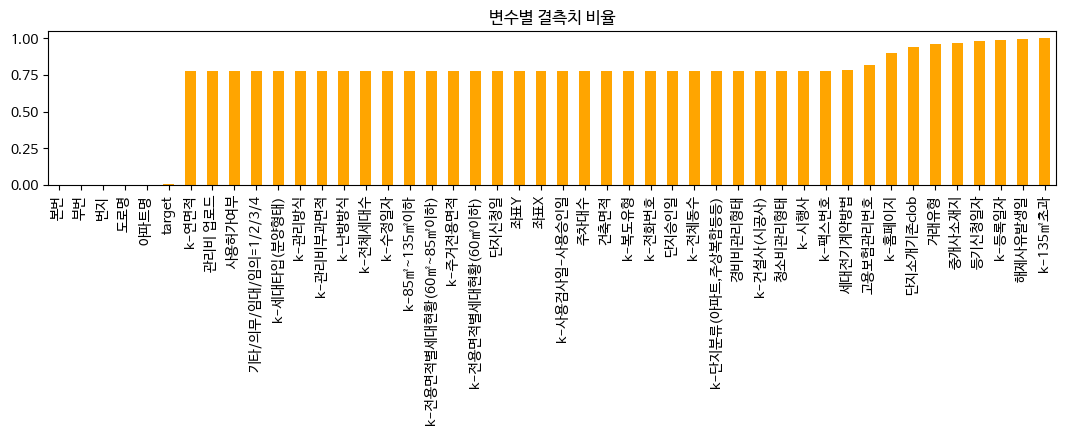

In [27]:
# 변수별 결측치의 비율을 plot으로 그려보면 아래와 같습니다.
fig = plt.figure(figsize=(13, 2))
missing = concat.isnull().sum() / concat.shape[0]
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar(color='orange')
plt.title('변수별 결측치 비율')
plt.show()

In [28]:
print(concat.shape[0] * 0.8)

902475.2000000001


In [29]:
# Null값이 90만개 이상인 칼럼은 삭제해보도록 하겠습니다.
print('* 결측치가 90만개 이하인 변수들 :', list(concat.columns[concat.isnull().sum() <= 900000]))     # 남겨질 변수들은 아래와 같습니다.
print('* 결측치가 90만개 이상인 변수들 :', list(concat.columns[concat.isnull().sum() >= 900000]))

* 결측치가 90만개 이하인 변수들 : ['시군구', '번지', '본번', '부번', '아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도', '도로명', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-수정일자', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y', '단지신청일', 'target', 'data']
* 결측치가 90만개 이상인 변수들 : ['해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', '단지소개기존clob', 'k-135㎡초과', 'k-홈페이지', 'k-등록일자', '고용보험관리번호']


In [30]:
# 결측치 90만개 이하 feature만 골라 새 변수에 저장

select = list(concat.columns[concat.isnull().sum() <= 900000])
concat_select = concat[select]

In [31]:
concat.shape, concat_select.shape

((1128094, 53), (1128094, 44))

In [32]:
concat_select.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1128094 entries, 0 to 9271
Data columns (total 44 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   시군구                     1128094 non-null  object 
 1   번지                      1127867 non-null  object 
 2   본번                      1128019 non-null  float64
 3   부번                      1128019 non-null  float64
 4   아파트명                    1125958 non-null  object 
 5   전용면적                    1128094 non-null  float64
 6   계약년월                    1128094 non-null  int64  
 7   계약일                     1128094 non-null  int64  
 8   층                       1128094 non-null  int64  
 9   건축년도                    1128094 non-null  int64  
 10  도로명                     1126883 non-null  object 
 11  k-단지분류(아파트,주상복합등등)      250821 non-null   object 
 12  k-전화번호                  251244 non-null   object 
 13  k-팩스번호                  248746 non-null   object 
 14  k-세대타

In [33]:
# 본번, 부번의 경우 float로 되어있지만 범주형 변수의 의미를 가지므로 object(string) 형태로 바꾸어주고 아래 작업을 진행하겠습니다.
concat_select['본번'] = concat_select['본번'].astype('str')
concat_select['부번'] = concat_select['부번'].astype('str')

In [34]:
# 먼저, 연속형 변수와 범주형 변수를 위 info에 따라 분리해주겠습니다.
# 숫자형 분리 pd.api.types.is_numeric_dtype
con_columns = []
cat_columns = []

for column in concat_select.columns:
    if pd.api.types.is_numeric_dtype(concat_select[column]):
        con_columns.append(column)
    else:
        cat_columns.append(column)

print("연속형 변수:", con_columns)
print("범주형 변수:", cat_columns)

연속형 변수: ['전용면적', '계약년월', '계약일', '층', '건축년도', 'k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', '건축면적', '주차대수', '좌표X', '좌표Y', 'target', 'data']
범주형 변수: ['시군구', '번지', '본번', '부번', '아파트명', '도로명', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-수정일자', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '단지신청일']


In [35]:
# 연속형 변수 결측치 비율
print("📊 연속형 변수 결측치 비율:")
for col in con_columns:
    null_ratio = concat_select[col].isnull().mean() * 100
    if null_ratio > 0:
        print(f"🔸 {col}: {null_ratio:.2f}%")

# 범주형 변수 결측치 비율
print("\n📊 범주형 변수 결측치 비율:")
for col in cat_columns:
    null_ratio = concat_select[col].isnull().mean() * 100
    if null_ratio > 0:
        print(f"🔸 {col}: {null_ratio:.2f}%")

📊 연속형 변수 결측치 비율:
🔸 k-전체동수: 77.76%
🔸 k-전체세대수: 77.66%
🔸 k-연면적: 77.66%
🔸 k-주거전용면적: 77.67%
🔸 k-관리비부과면적: 77.66%
🔸 k-전용면적별세대현황(60㎡이하): 77.67%
🔸 k-전용면적별세대현황(60㎡~85㎡이하): 77.67%
🔸 k-85㎡~135㎡이하: 77.67%
🔸 건축면적: 77.68%
🔸 주차대수: 77.68%
🔸 좌표X: 77.67%
🔸 좌표Y: 77.67%
🔸 target: 0.82%

📊 범주형 변수 결측치 비율:
🔸 번지: 0.02%
🔸 아파트명: 0.19%
🔸 도로명: 0.11%
🔸 k-단지분류(아파트,주상복합등등): 77.77%
🔸 k-전화번호: 77.73%
🔸 k-팩스번호: 77.95%
🔸 k-세대타입(분양형태): 77.66%
🔸 k-관리방식: 77.66%
🔸 k-복도유형: 77.69%
🔸 k-난방방식: 77.66%
🔸 k-건설사(시공사): 77.80%
🔸 k-시행사: 77.91%
🔸 k-사용검사일-사용승인일: 77.68%
🔸 k-수정일자: 77.67%
🔸 경비비관리형태: 77.79%
🔸 세대전기계약방법: 78.49%
🔸 청소비관리형태: 77.81%
🔸 기타/의무/임대/임의=1/2/3/4: 77.66%
🔸 단지승인일: 77.73%
🔸 사용허가여부: 77.66%
🔸 관리비 업로드: 77.66%
🔸 단지신청일: 77.67%


In [36]:
def null_summary(df, columns):
    result = pd.DataFrame({
        '결측 개수': df[columns].isnull().sum(),
        '결측 비율(%)': df[columns].isnull().mean() * 100
    })
    return result[result['결측 개수'] > 0].sort_values('결측 비율(%)', ascending=False)

print("📊 연속형 변수 결측치 요약")
display(null_summary(concat_select, con_columns))

print("📊 범주형 변수 결측치 요약")
display(null_summary(concat_select, cat_columns))


📊 연속형 변수 결측치 요약


,결측 개수,결측 비율(%)
k-전체동수,877207,77.760098
건축면적,876279,77.677835
주차대수,876277,77.677658
좌표X,876232,77.673669
좌표Y,876232,77.673669
k-주거전용면적,876170,77.668173
k-전용면적별세대현황(60㎡이하),876170,77.668173
k-전용면적별세대현황(60㎡~85㎡이하),876170,77.668173
k-85㎡~135㎡이하,876170,77.668173
k-전체세대수,876125,77.664184


📊 범주형 변수 결측치 요약


,결측 개수,결측 비율(%)
세대전기계약방법,885389,78.485392
k-팩스번호,879348,77.949887
k-시행사,878854,77.906096
청소비관리형태,877751,77.808321
k-건설사(시공사),877637,77.798215
경비비관리형태,877561,77.791478
"k-단지분류(아파트,주상복합등등)",877273,77.765949
단지승인일,876854,77.728806
k-전화번호,876850,77.728452
k-복도유형,876454,77.693348


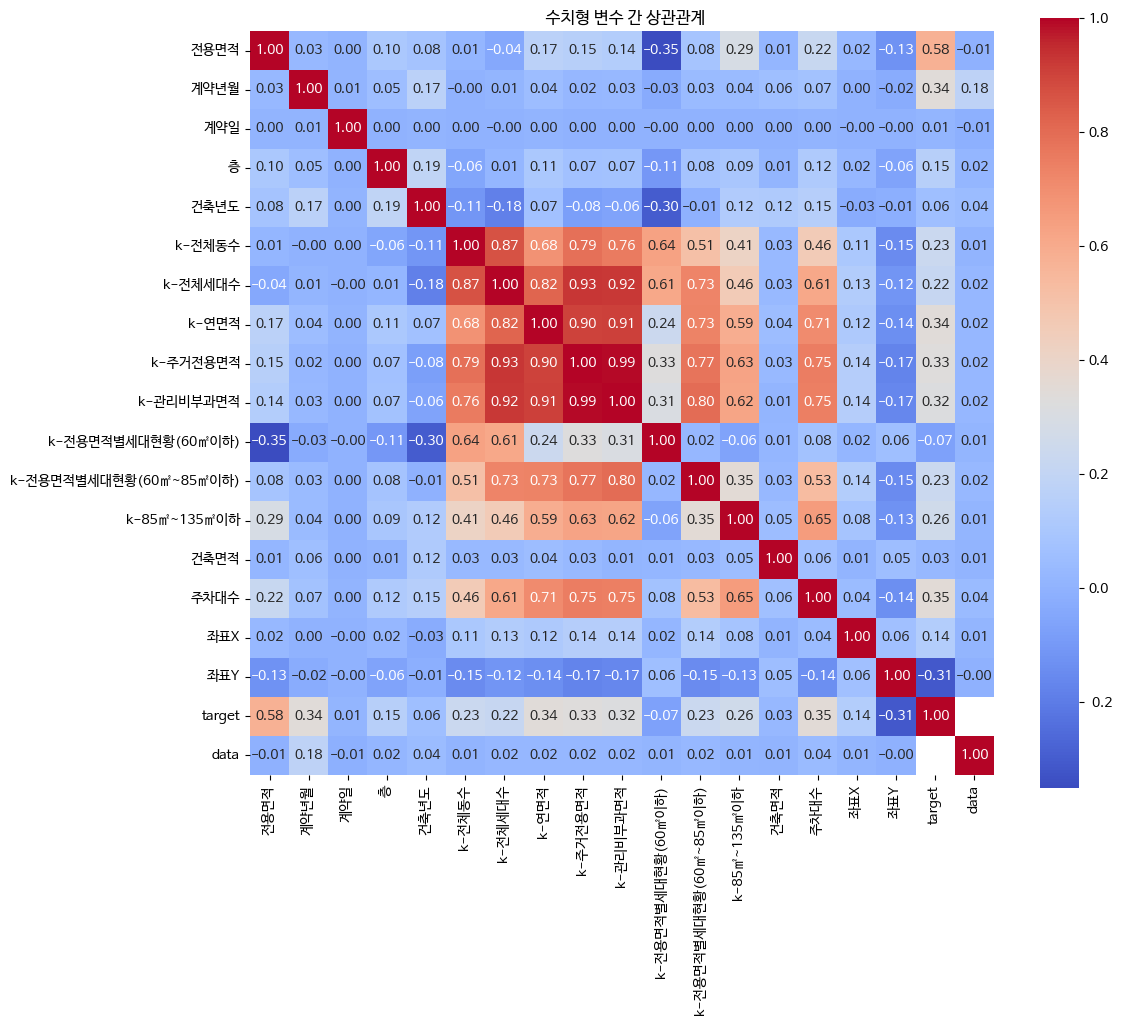

In [37]:
# 결측치 탐지 및 처리 전 연속형 변수 상관관계 보기

# 1. 수치형 변수만 선택
numeric_cols = concat_select.select_dtypes(include=['float64', 'int64']).columns

# 2. 상관관계 계산
corr = concat_select[numeric_cols].corr()

# 3. 시각화
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("📊 수치형 변수 간 상관관계")
plt.show()

In [38]:
#상관관계 기반으로 중복 feature 쌍 탐지 및 삭제 후보 추천

# 연속형 변수만 추출
numeric_cols = con_columns  # ← 너가 나눠둔 연속형 변수 리스트

# 상관관계 행렬 (절댓값 기준)
corr_matrix = concat_select[numeric_cols].corr().abs()

# 상삼각 행렬로 중복 제거
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# 상관계수 0.9 초과인 변수쌍 추출
high_corr_pairs = [(col, row, upper.loc[row, col])
                   for col in upper.columns
                   for row in upper.index
                   if pd.notnull(upper.loc[row, col]) and upper.loc[row, col] > 0.9]

# 출력
for col1, col2, score in sorted(high_corr_pairs, key=lambda x: -x[2]):
    print(f"🔁 {col1} ↔ {col2} : 상관계수 = {score:.2f}")


🔁 k-관리비부과면적 ↔ k-주거전용면적 : 상관계수 = 0.99
🔁 k-주거전용면적 ↔ k-전체세대수 : 상관계수 = 0.93
🔁 k-관리비부과면적 ↔ k-전체세대수 : 상관계수 = 0.92
🔁 k-관리비부과면적 ↔ k-연면적 : 상관계수 = 0.91
🔁 k-주거전용면적 ↔ k-연면적 : 상관계수 = 0.90


In [39]:
# 사실상 결측치 처리 없이 상관관계 보는 건 의미가 없었고...
# 보간을 진행

# 선형보간할 변수
interpolate_cols = ['k-주거전용면적', 'k-관리비부과면적', 'k-연면적', '건축면적']
# 선형 보간
for col in interpolate_cols:
    concat_select[col] = concat_select[col].interpolate(method='linear', limit_direction='both')
    
# 중앙값 보간 변수
median_cols = ['k-전체동수', 'k-전체세대수', '주차대수', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하']
# 중앙값 보간
for col in median_cols:
    median = concat_select[col].median()
    concat_select[col] = concat_select[col].fillna(median)

In [40]:
concat_select.isnull().sum()

시군구                            0
번지                           227
본번                             0
부번                             0
아파트명                        2136
전용면적                           0
계약년월                           0
계약일                            0
층                              0
건축년도                           0
도로명                         1211
k-단지분류(아파트,주상복합등등)        877273
k-전화번호                    876850
k-팩스번호                    879348
k-세대타입(분양형태)              876125
k-관리방식                    876125
k-복도유형                    876454
k-난방방식                    876125
k-전체동수                         0
k-전체세대수                        0
k-건설사(시공사)                877637
k-시행사                     878854
k-사용검사일-사용승인일             876259
k-연면적                          0
k-주거전용면적                       0
k-관리비부과면적                      0
k-전용면적별세대현황(60㎡이하)             0
k-전용면적별세대현황(60㎡~85㎡이하)         0
k-85㎡~135㎡이하                   0
k-수정일자                    876170
경비비관리형태   

In [41]:
# 모자이크 플롯이나 카이제곱 통계량은 결측치가 있으면 안 된다고 해서...
# 범주형 변수에 대한 보간
concat_select[cat_columns] = concat_select[cat_columns].fillna('Unknown')

In [42]:
# 범주형 변수 카이제곱 통계량 보기

from scipy.stats import chi2_contingency
from itertools import combinations

def run_chi_square_tests(concat_select, cat_columns, alpha=0.05):
    significant_pairs = []
    
    for col1, col2 in combinations(cat_columns, 2):
        try:
            contingency = pd.crosstab(concat_select[col1], concat_select[col2])
            if contingency.shape[0] < 2 or contingency.shape[1] < 2:
                continue  # 유의미한 검정이 불가능한 조합 skip
            chi2, p, dof, expected = chi2_contingency(contingency)
            if p < alpha:
                print(f"✅ {col1} vs {col2} → p = {p:.5f} ★ 유의미한 관계 있음")
                significant_pairs.append((col1, col2, p))
        except Exception as e:
            print(f"⚠️ {col1} vs {col2} 오류: {e}")
    
    return significant_pairs


In [43]:
# 카이제곱 검정 수행
significant_results = run_chi_square_tests(concat_select, cat_columns)


✅ 시군구 vs 번지 → p = 0.00000 ★ 유의미한 관계 있음
✅ 시군구 vs 본번 → p = 0.00000 ★ 유의미한 관계 있음
✅ 시군구 vs 부번 → p = 0.00000 ★ 유의미한 관계 있음
✅ 시군구 vs 아파트명 → p = 0.00000 ★ 유의미한 관계 있음
✅ 시군구 vs 도로명 → p = 0.00000 ★ 유의미한 관계 있음
✅ 시군구 vs k-단지분류(아파트,주상복합등등) → p = 0.00000 ★ 유의미한 관계 있음
✅ 시군구 vs k-전화번호 → p = 0.00000 ★ 유의미한 관계 있음
✅ 시군구 vs k-팩스번호 → p = 0.00000 ★ 유의미한 관계 있음
✅ 시군구 vs k-세대타입(분양형태) → p = 0.00000 ★ 유의미한 관계 있음
✅ 시군구 vs k-관리방식 → p = 0.00000 ★ 유의미한 관계 있음
✅ 시군구 vs k-복도유형 → p = 0.00000 ★ 유의미한 관계 있음
✅ 시군구 vs k-난방방식 → p = 0.00000 ★ 유의미한 관계 있음
✅ 시군구 vs k-건설사(시공사) → p = 0.00000 ★ 유의미한 관계 있음
✅ 시군구 vs k-시행사 → p = 0.00000 ★ 유의미한 관계 있음
✅ 시군구 vs k-사용검사일-사용승인일 → p = 0.00000 ★ 유의미한 관계 있음
✅ 시군구 vs k-수정일자 → p = 0.00000 ★ 유의미한 관계 있음
✅ 시군구 vs 경비비관리형태 → p = 0.00000 ★ 유의미한 관계 있음
✅ 시군구 vs 세대전기계약방법 → p = 0.00000 ★ 유의미한 관계 있음
✅ 시군구 vs 청소비관리형태 → p = 0.00000 ★ 유의미한 관계 있음
✅ 시군구 vs 기타/의무/임대/임의=1/2/3/4 → p = 0.00000 ★ 유의미한 관계 있음
✅ 시군구 vs 단지승인일 → p = 0.00000 ★ 유의미한 관계 있음
✅ 시군구 vs 사용허가여부 → p = 0.00000 ★ 유의미한 관계 있음
✅ 시군구 vs 관리비 업로드 → p = 0.00

In [45]:
for col1, col2, p in significant_results[:10]:  # 상위 10개만 보기
    print(f"✅ {col1} vs {col2} → p-value = {p:.5f}")

✅ 시군구 vs 번지 → p-value = 0.00000
✅ 시군구 vs 본번 → p-value = 0.00000
✅ 시군구 vs 부번 → p-value = 0.00000
✅ 시군구 vs 아파트명 → p-value = 0.00000
✅ 시군구 vs 도로명 → p-value = 0.00000
✅ 시군구 vs k-단지분류(아파트,주상복합등등) → p-value = 0.00000
✅ 시군구 vs k-전화번호 → p-value = 0.00000
✅ 시군구 vs k-팩스번호 → p-value = 0.00000
✅ 시군구 vs k-세대타입(분양형태) → p-value = 0.00000
✅ 시군구 vs k-관리방식 → p-value = 0.00000


In [46]:
# Cramer's V (크래머스 브이) 기반으로 범주형 변수들 간 관계 강도 보기

from scipy.stats import chi2_contingency
from itertools import combinations
import pandas as pd
import numpy as np

def cramers_v(confusion_matrix):
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k - 1, r - 1))

def run_cramers_v_tests(concat_select, cat_columns, alpha=0.05):
    results = []

    for col1, col2 in combinations(cat_columns, 2):
        try:
            contingency = pd.crosstab(concat_select[col1], concat_select[col2])

            if contingency.shape[0] < 2 or contingency.shape[1] < 2:
                continue

            chi2, p, _, _ = chi2_contingency(contingency)
            v = cramers_v(contingency)

            if p < alpha:
                results.append((col1, col2, p, v))  # 컬럼1, 컬럼2, p값, Cramér's V
        except Exception as e:
            print(f"❗ {col1} vs {col2} 오류: {e}")

    # Cramér's V 기준으로 내림차순 정렬
    results.sort(key=lambda x: x[3], reverse=True)

    return results


In [47]:
results = run_cramers_v_tests(concat_select, cat_columns)

# 상위 10개만 보기
for col1, col2, p, v in results[:10]:
    print(f"🔍 {col1} vs {col2} → p-value: {p:.5f}, Cramér's V: {v:.3f}")

🔍 k-단지분류(아파트,주상복합등등) vs k-전화번호 → p-value: 0.00000, Cramér's V: 1.000
🔍 k-단지분류(아파트,주상복합등등) vs k-수정일자 → p-value: 0.00000, Cramér's V: 1.000
🔍 k-세대타입(분양형태) vs 사용허가여부 → p-value: 0.00000, Cramér's V: 1.000
🔍 k-관리방식 vs 사용허가여부 → p-value: 0.00000, Cramér's V: 1.000
🔍 k-난방방식 vs 사용허가여부 → p-value: 0.00000, Cramér's V: 1.000
🔍 경비비관리형태 vs 단지승인일 → p-value: 0.00000, Cramér's V: 1.000
🔍 세대전기계약방법 vs 단지승인일 → p-value: 0.00000, Cramér's V: 1.000
🔍 청소비관리형태 vs 단지승인일 → p-value: 0.00000, Cramér's V: 1.000
🔍 기타/의무/임대/임의=1/2/3/4 vs 사용허가여부 → p-value: 0.00000, Cramér's V: 1.000
🔍 사용허가여부 vs 관리비 업로드 → p-value: 0.00000, Cramér's V: 1.000


In [48]:
# 모두 출력
for col1, col2, p, v in results:
    print(f"{col1} vs {col2} → p-value: {p:.5f}, Cramér's V: {v:.3f}")

k-단지분류(아파트,주상복합등등) vs k-전화번호 → p-value: 0.00000, Cramér's V: 1.000
k-단지분류(아파트,주상복합등등) vs k-수정일자 → p-value: 0.00000, Cramér's V: 1.000
k-세대타입(분양형태) vs 사용허가여부 → p-value: 0.00000, Cramér's V: 1.000
k-관리방식 vs 사용허가여부 → p-value: 0.00000, Cramér's V: 1.000
k-난방방식 vs 사용허가여부 → p-value: 0.00000, Cramér's V: 1.000
경비비관리형태 vs 단지승인일 → p-value: 0.00000, Cramér's V: 1.000
세대전기계약방법 vs 단지승인일 → p-value: 0.00000, Cramér's V: 1.000
청소비관리형태 vs 단지승인일 → p-value: 0.00000, Cramér's V: 1.000
기타/의무/임대/임의=1/2/3/4 vs 사용허가여부 → p-value: 0.00000, Cramér's V: 1.000
사용허가여부 vs 관리비 업로드 → p-value: 0.00000, Cramér's V: 1.000
k-시행사 vs k-수정일자 → p-value: 0.00000, Cramér's V: 1.000
k-수정일자 vs 청소비관리형태 → p-value: 0.00000, Cramér's V: 1.000
k-관리방식 vs k-수정일자 → p-value: 0.00000, Cramér's V: 1.000
k-복도유형 vs k-수정일자 → p-value: 0.00000, Cramér's V: 1.000
k-난방방식 vs k-수정일자 → p-value: 0.00000, Cramér's V: 1.000
k-세대타입(분양형태) vs k-수정일자 → p-value: 0.00000, Cramér's V: 1.000
k-수정일자 vs 관리비 업로드 → p-value: 0.00000, Cramér's V: 1.000
k-수정일자 vs 세대전

In [50]:
import pandas as pd

df_cramer = pd.DataFrame(results, columns=['col1', 'col2', 'p_value', 'cramers_v'])

# cramers_v 기준 정렬
df_cramer_sorted = df_cramer.sort_values(by='cramers_v', ascending=False)

# 상위 20개 보기
display(df_cramer_sorted)


,col1,col2,p_value,cramers_v
0,"k-단지분류(아파트,주상복합등등)",k-전화번호,0.0,1.000000
6,세대전기계약방법,단지승인일,0.0,1.000000
1,"k-단지분류(아파트,주상복합등등)",k-수정일자,0.0,1.000000
8,기타/의무/임대/임의=1/2/3/4,사용허가여부,0.0,1.000000
7,청소비관리형태,단지승인일,0.0,1.000000
9,사용허가여부,관리비 업로드,0.0,1.000000
5,경비비관리형태,단지승인일,0.0,1.000000
4,k-난방방식,사용허가여부,0.0,1.000000
3,k-관리방식,사용허가여부,0.0,1.000000
2,k-세대타입(분양형태),사용허가여부,0.0,1.000000


In [53]:
# 크래머스 브이 ; 시군구 기준으로 보기
df_cramer[df_cramer['col1'] == '시군구'].sort_values(by='cramers_v', ascending=False).head(10)

,col1,col2,p_value,cramers_v
60,시군구,도로명,0.0,0.996213
139,시군구,아파트명,0.0,0.885228
175,시군구,번지,0.0,0.778993
233,시군구,k-세대타입(분양형태),0.0,0.612758
246,시군구,본번,0.0,0.536724
253,시군구,기타/의무/임대/임의=1/2/3/4,0.0,0.511799
260,시군구,사용허가여부,0.0,0.497881
261,시군구,k-난방방식,0.0,0.487228
263,시군구,k-수정일자,0.0,0.458761
264,시군구,k-전화번호,0.0,0.458568


In [51]:
# 저장할 경로
save_path = '/root/AI_STAGE/upstageailab-ml-competition-ml-2/1.Data/cramers_v_results.csv'

# CSV 파일로 저장
df_cramer.to_csv(save_path, index=False, encoding='utf-8-sig')  # 한글 포함 시 utf-8-sig 권장


In [58]:
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic

def plot_top_mosaics(df_cramer, concat_select, top_n=5, base_col='시군구'):
    # 'base_col'이 포함된 col1 기준 상위 N개 필터링
    top_pairs = df_cramer[df_cramer['col1'] == base_col].sort_values(by='cramers_v', ascending=False).head(top_n)

    for _, row in top_pairs.iterrows():
        col1, col2 = row['col1'], row['col2']

        # 결측치 대체 (플롯을 위해 반드시 필요)
        # data = concat_select[[col1, col2]].fillna('Unknown').astype(str)

        # 카테고리 수가 너무 많을 경우 경고
        if concat_select[col1].nunique() > 20 or concat_select[col2].nunique() > 20:
            print(f"⚠️ {col1} 또는 {col2}의 유일값이 너무 많아 시각화가 어려울 수 있음")
            continue

        # 모자이크 플롯 생성
        plt.figure(figsize=(10, 6))
        mosaic(concat_select, [col1, col2])
        plt.title(f"Mosaic Plot: {col1} vs {col2} (Cramér's V: {row['cramers_v']:.3f})")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()



In [59]:
plot_top_mosaics(df_cramer, concat_select, top_n=5, base_col='시군구')

⚠️ 시군구 또는 도로명의 유일값이 너무 많아 시각화가 어려울 수 있음
⚠️ 시군구 또는 아파트명의 유일값이 너무 많아 시각화가 어려울 수 있음
⚠️ 시군구 또는 번지의 유일값이 너무 많아 시각화가 어려울 수 있음
⚠️ 시군구 또는 k-세대타입(분양형태)의 유일값이 너무 많아 시각화가 어려울 수 있음
⚠️ 시군구 또는 본번의 유일값이 너무 많아 시각화가 어려울 수 있음


In [60]:
concat_select.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1128094 entries, 0 to 9271
Data columns (total 44 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   시군구                     1128094 non-null  object 
 1   번지                      1128094 non-null  object 
 2   본번                      1128094 non-null  object 
 3   부번                      1128094 non-null  object 
 4   아파트명                    1128094 non-null  object 
 5   전용면적                    1128094 non-null  float64
 6   계약년월                    1128094 non-null  int64  
 7   계약일                     1128094 non-null  int64  
 8   층                       1128094 non-null  int64  
 9   건축년도                    1128094 non-null  int64  
 10  도로명                     1128094 non-null  object 
 11  k-단지분류(아파트,주상복합등등)      1128094 non-null  object 
 12  k-전화번호                  1128094 non-null  object 
 13  k-팩스번호                  1128094 non-null  object 
 14  k-세대타

In [61]:
concat_select.isnull().sum()

시군구                            0
번지                             0
본번                             0
부번                             0
아파트명                           0
전용면적                           0
계약년월                           0
계약일                            0
층                              0
건축년도                           0
도로명                            0
k-단지분류(아파트,주상복합등등)             0
k-전화번호                         0
k-팩스번호                         0
k-세대타입(분양형태)                   0
k-관리방식                         0
k-복도유형                         0
k-난방방식                         0
k-전체동수                         0
k-전체세대수                        0
k-건설사(시공사)                     0
k-시행사                          0
k-사용검사일-사용승인일                  0
k-연면적                          0
k-주거전용면적                       0
k-관리비부과면적                      0
k-전용면적별세대현황(60㎡이하)             0
k-전용면적별세대현황(60㎡~85㎡이하)         0
k-85㎡~135㎡이하                   0
k-수정일자                         0
경비비관리형태   

In [63]:
# 결측치가 있는 컬럼만 보기
null_columns = concat_select.columns[concat_select.isnull().any()]
print("결측치 있는 변수:", list(null_columns))


결측치 있는 변수: ['좌표X', '좌표Y', 'target']


In [64]:
# 결측치 개수 확인
missing_info = concat_select[null_columns].isnull().sum().sort_values(ascending=False)
print(missing_info)


좌표X       876232
좌표Y       876232
target      9272
dtype: int64


In [65]:
# 다르게 처리할 방법이 떠오르지 않아서 선형 보간 함
for col in ['좌표X', '좌표Y']:
    concat_select[col] = concat_select[col].interpolate(method='linear', limit_direction='both')


# 결측치 개수 확인
missing_info = concat_select[null_columns].isnull().sum().sort_values(ascending=False)
print(missing_info)


target    9272
좌표X          0
좌표Y          0
dtype: int64


In [66]:
# 학습셋에서만 target 결측 여부 확인
null_target_in_train = concat_select[(concat_select['data'] == 0) & (concat_select['target'].isnull())]

if null_target_in_train.empty:
    print("✅ 학습셋에는 target 결측 없음 — 처리 불필요!")
else:
    print("⚠️ 학습셋에 target 결측 존재 — 삭제해야 함")


✅ 학습셋에는 target 결측 없음 — 처리 불필요!


In [67]:
## 이상치 탐지

print(concat_select.shape)

(1128094, 44)


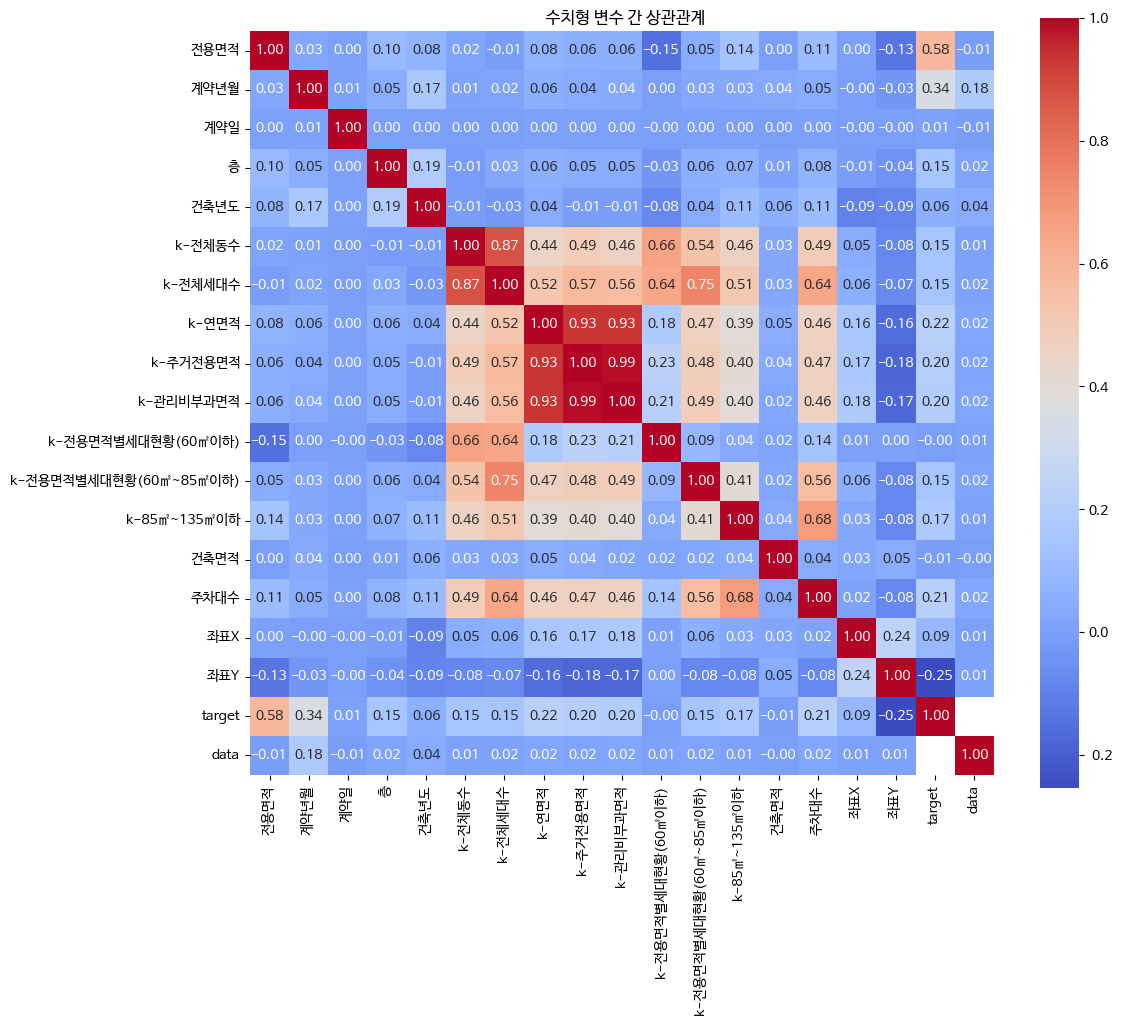

In [68]:
# 이상치 처리 전 연속형 변수 상관관계 보기

# 1. 수치형 변수만 선택
numeric_cols = concat_select.select_dtypes(include=['float64', 'int64']).columns

# 2. 상관관계 계산
corr = concat_select[numeric_cols].corr()

# 3. 시각화
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("📊 수치형 변수 간 상관관계")
plt.show()

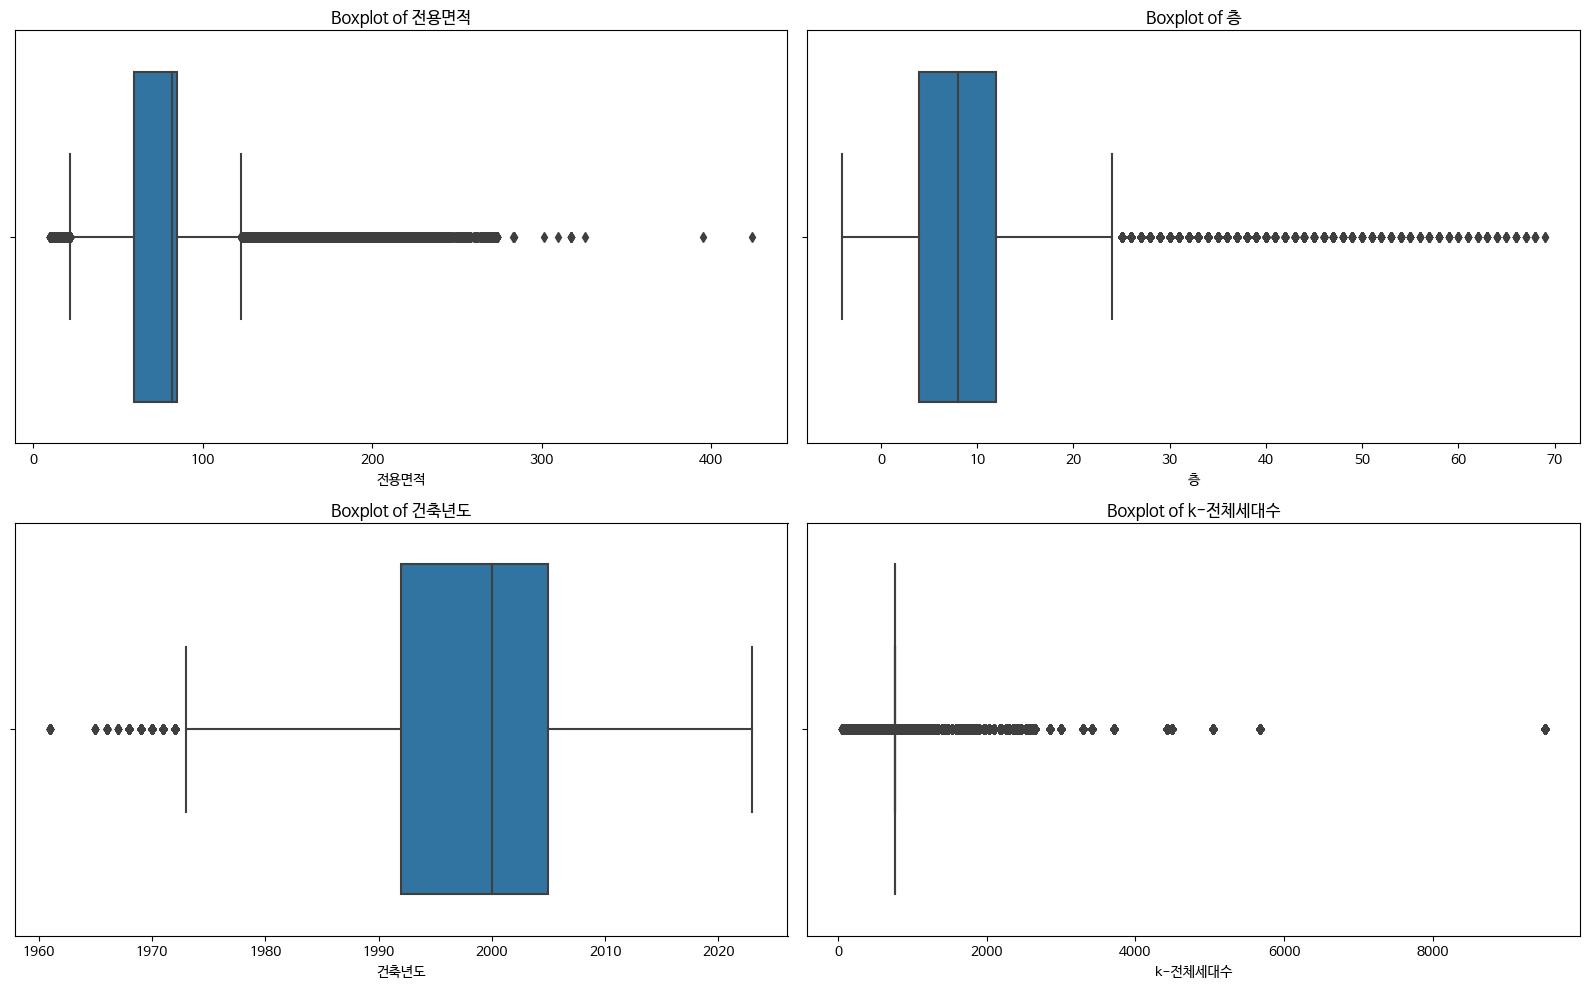

In [71]:
# '전용 면적', '층', '건축년도', 'k-전체세대수' 이상치 탐지

# 박스플롯으로 보고 싶은 컬럼들
cols_to_plot = ['전용면적', '층', '건축년도', 'k-전체세대수']  # 실제 변수명이 정확한지 확인

# subplot 설정
plt.figure(figsize=(16, 10))  # 넓은 그래프

for i, col in enumerate(cols_to_plot, 1):
    plt.subplot(2, 2, i)  # 2행 2열 subplot
    sns.boxplot(data=concat_select[concat_select['data'] == 0], x=col)  # 학습용 데이터만 보기
    plt.title(f"Boxplot of {col}")
    plt.tight_layout()

plt.show()
